## Trait-management performance
Quantifying performance of different trait combinations in terms of __yield__ & __yield stability__

In [3]:
from ideotype.data_process import read_data, parse_mature
from ideotype.analysis import rank_top_phenos
from ideotype.figures import (plot_yield_disp_scatter,
                              plot_yield_stability_scatter_norm,
                              plot_yield_stability_scatter_performance,
                              plot_yield_disp_heatmap,
                              plot_performance_heatmap,
                              plot_top_performance_heatmap,
                              plot_params_heatmap,
                              plot_params_heatmap_all,
                              plot_top_performance_maps,
                              plot_top_performance_maps_shift)

In [2]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

### High performing trait-management combination for each site

Yield vs. yield dispersion (variance/mean):

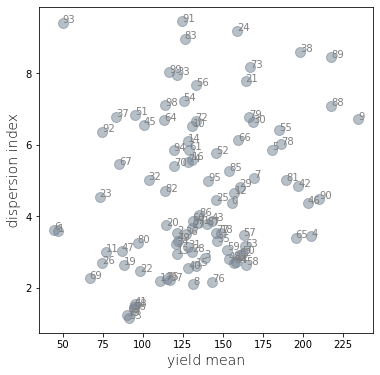

In [6]:
plot_yield_disp_scatter(df_all)

Standardized yield vs. yield stability (1 - standardized dispersion):

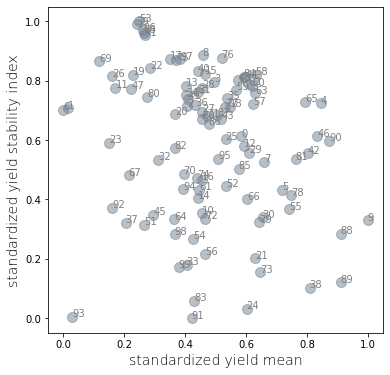

In [7]:
plot_yield_stability_scatter_norm()

Standardized yield vs. yield stability with performance (darker purple = higher performance ranking):

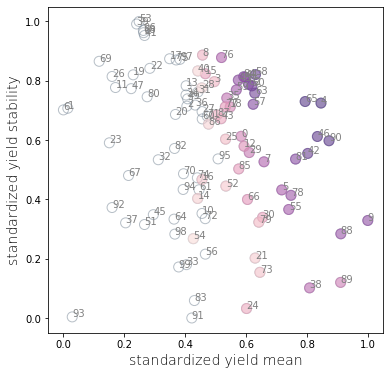

In [9]:
plot_yield_stability_scatter_performance()

### Identify top performing trait-management combinations
- Currently, the top performers are also the ones that perform uniformally well across sites
- Which also probably means they have less of a resposne to climate variability across sites
- How to rank all phenotypes but only rank to, say, top 10?

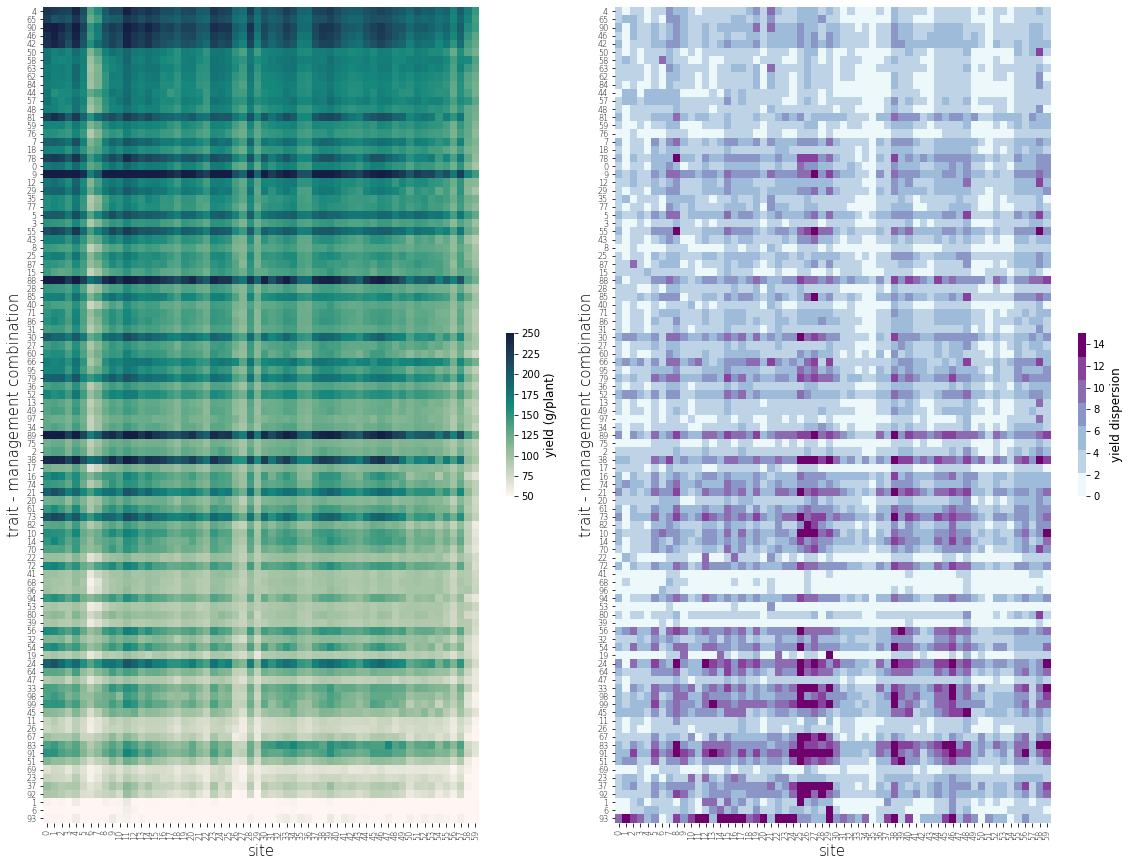

In [6]:
plot_yield_disp_heatmap(df_all, 'present')

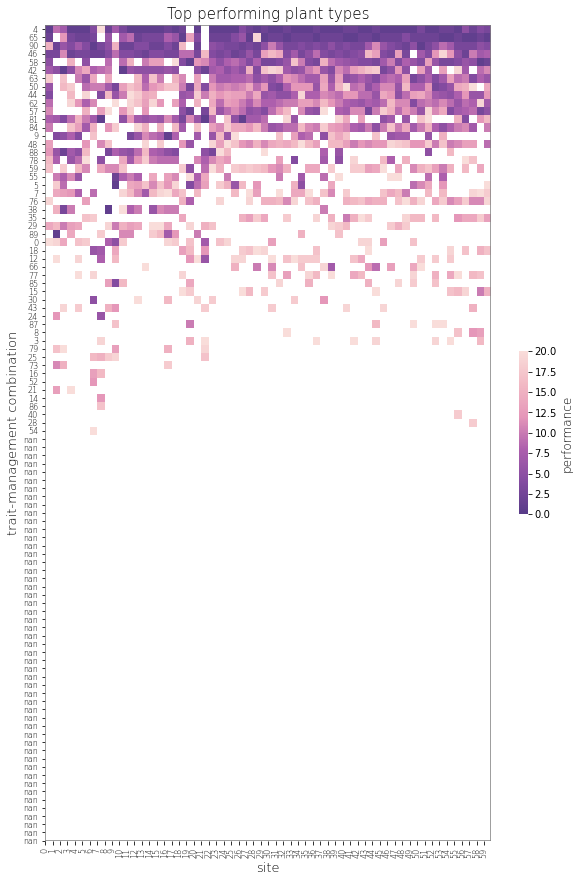

In [7]:
plot_performance_heatmap(df_all, 'present', 1, 1)

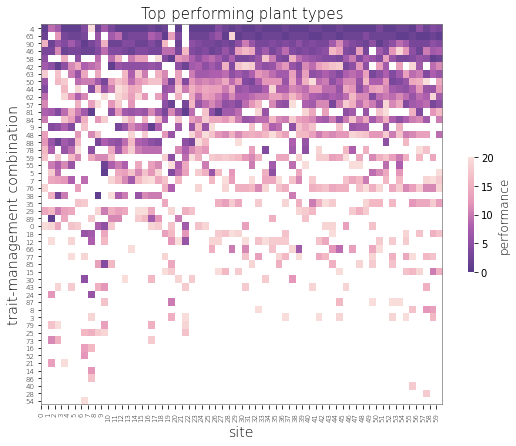

In [8]:
plot_top_performance_heatmap(df_all, 'present', 20, 1, 1)

### Perturbed parameter values for top performers

All perturbed parameters:

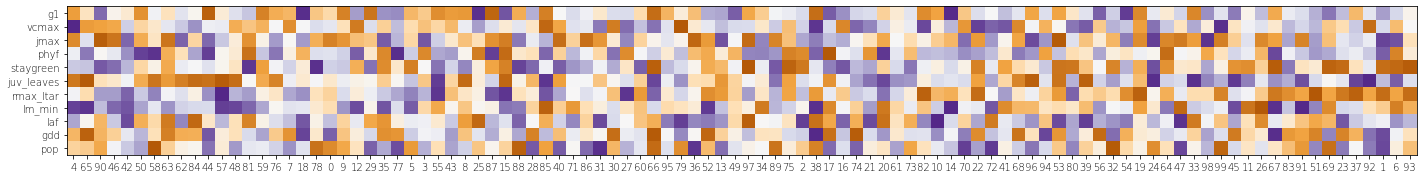

In [9]:
plot_params_heatmap_all(df_params)

Present day top 20 plant types:

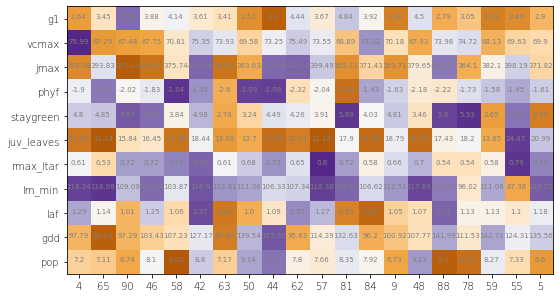

In [10]:
top_phenos = rank_top_phenos('present', 20, 1, 1)
plot_params_heatmap(df_params, top_phenos)

End of century (2100) top 20 plant types:

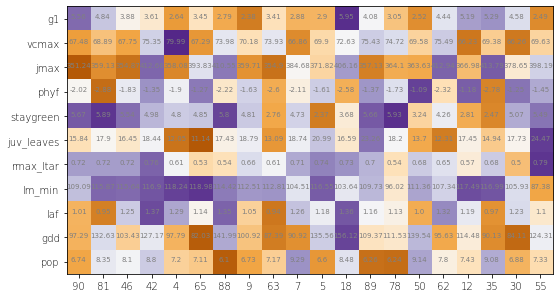

In [11]:
top_phenos = rank_top_phenos('f2100', 20, 1, 1)
plot_params_heatmap(df_params, top_phenos)

### Top phenotype performance across sites

Present day:

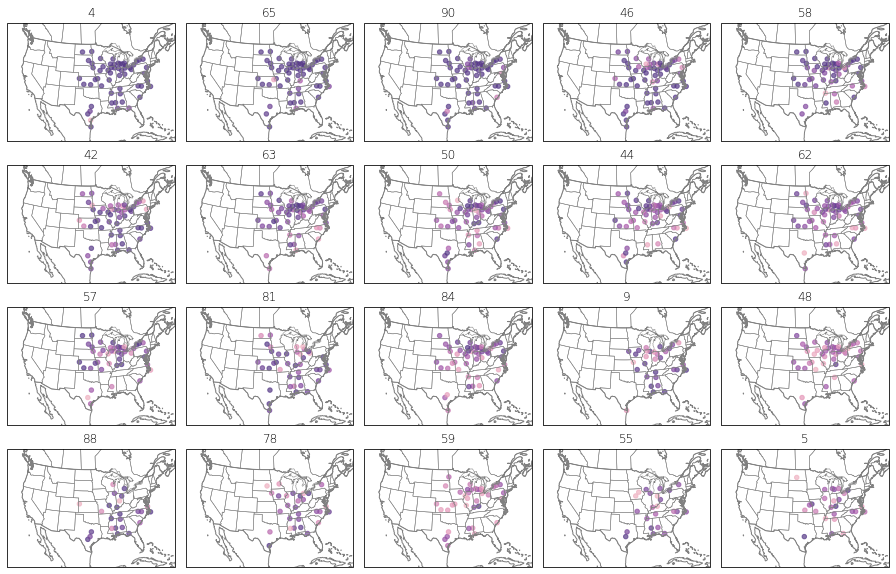

In [12]:
plot_top_performance_maps(df_sites, 'present', 20, 1, 1)

Future performance of top 20 plant types identified today:

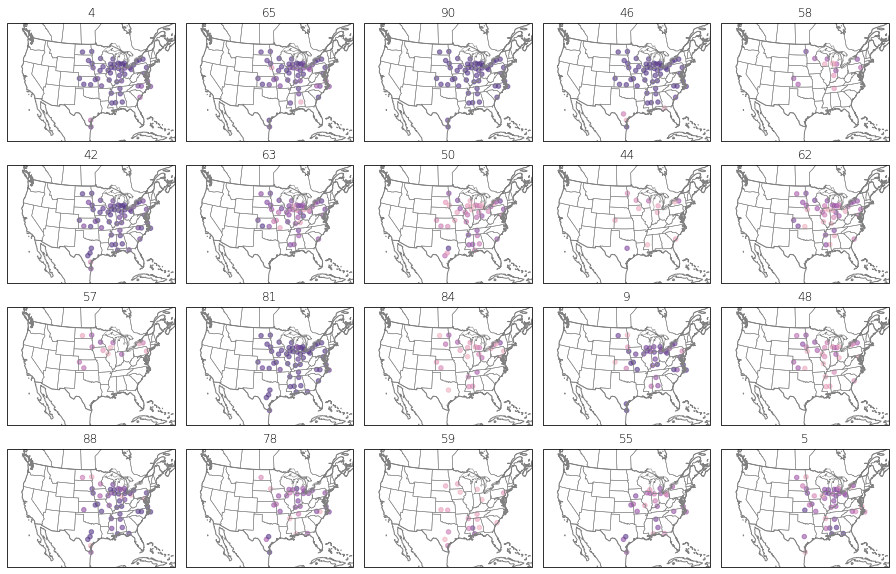

In [13]:
plot_top_performance_maps_shift(df_sites, 'present', 'f2100', 20, 1, 1)

End of century (2100) top performers:

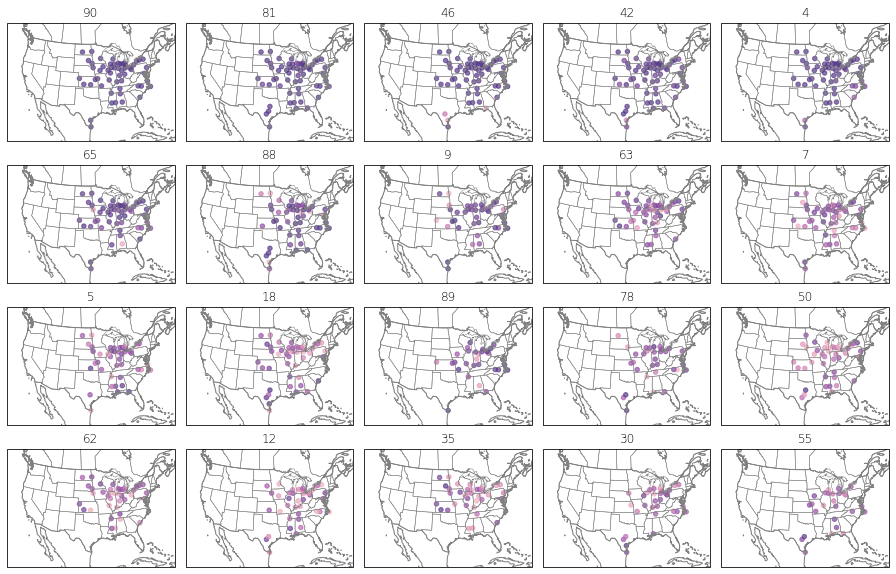

In [14]:
plot_top_performance_maps(df_sites, 'f2100', 20, 1, 1)